# Day 1: Probability Distributions in Finance

## Week 2 - Statistics & Probability for Quantitative Finance

### 🎯 Learning Objectives
- Understand key probability distributions used in finance
- Fit distributions to real financial data
- Compare Normal vs Student-t for modeling returns
- Quantify tail risk using distribution parameters

### Why Distributions Matter
- Risk models depend on distribution assumptions
- Wrong distribution → Wrong VaR/ES estimates
- Fat tails are a reality in financial markets

**Author**: ML Quant Finance Mastery | **Difficulty**: Foundation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Load market data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                  index_col=0, parse_dates=True)

# Calculate returns
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("PROBABILITY DISTRIBUTIONS IN FINANCE - DAY 1")
print("=" * 60)
print(f"\nData: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Observations: {len(returns):,}")
print(f"Assets: {', '.join(returns.columns)}")

PROBABILITY DISTRIBUTIONS IN FINANCE - DAY 1

Data: 2019-01-03 to 2026-01-16
Observations: 1,770
Assets: AAPL, MSFT, SPY, JPM


## 1. The Normal Distribution - Foundation & Limitations

The **Normal (Gaussian) distribution** is the starting point for financial modeling:

$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

**Key Properties:**
- Fully characterized by mean (μ) and standard deviation (σ)
- 68% within ±1σ, 95% within ±2σ, 99.7% within ±3σ
- Symmetric around the mean

**Why It Fails in Finance:**
- Real returns have "fat tails" (more extreme events than Normal predicts)
- Returns show negative skewness (bigger down moves than up)
- Volatility clusters (not constant σ)

FITTING NORMAL DISTRIBUTION TO SPY RETURNS

Estimated Parameters:
  Mean (μ):     0.000712 (17.94% annualized)
  Std Dev (σ):  0.012422 (19.72% annualized)

Normality Test (D'Agostino-Pearson):
  Test statistic: 403.9452
  P-value:        0.000000
  Conclusion:     NOT Normal (α=0.05)


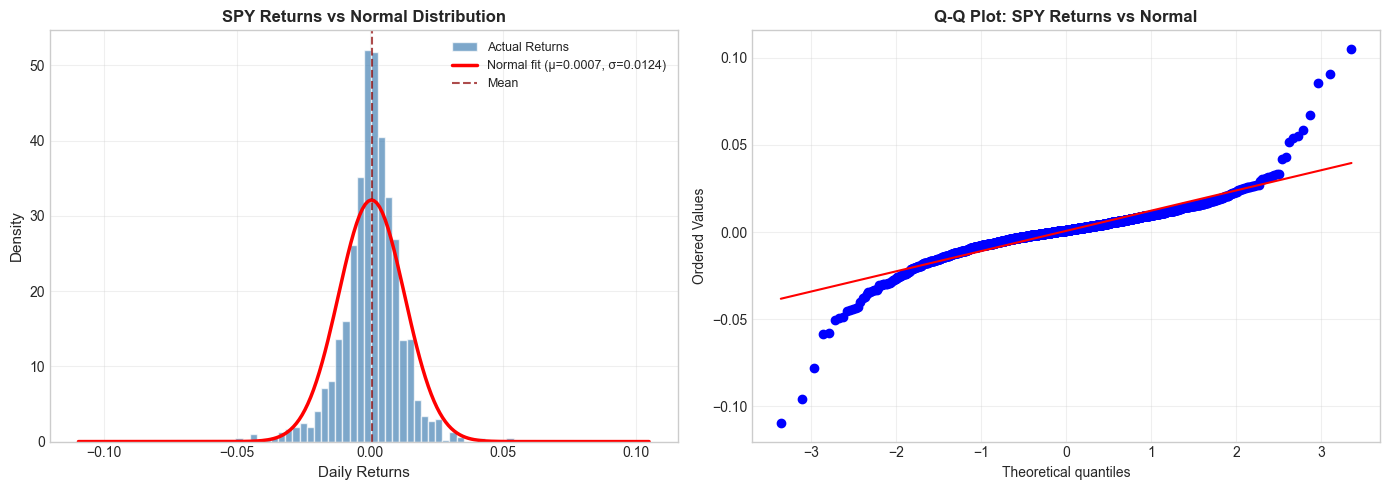


📊 Q-Q Plot Interpretation:
   - Points on diagonal → Normal distribution
   - Curved tails → Fat tails (common in finance)
   - S-shape → Skewness


In [2]:
# Fit Normal distribution to SPY returns
spy_returns = returns['SPY'].values

# Calculate Normal parameters (MLE)
mu_normal = np.mean(spy_returns)
sigma_normal = np.std(spy_returns)

print("=" * 60)
print("FITTING NORMAL DISTRIBUTION TO SPY RETURNS")
print("=" * 60)
print(f"\nEstimated Parameters:")
print(f"  Mean (μ):     {mu_normal:.6f} ({mu_normal * 252:.2%} annualized)")
print(f"  Std Dev (σ):  {sigma_normal:.6f} ({sigma_normal * np.sqrt(252):.2%} annualized)")

# Create fitted distribution
normal_dist = stats.norm(loc=mu_normal, scale=sigma_normal)

# Test goodness of fit
stat, p_value = stats.normaltest(spy_returns)
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"  Test statistic: {stat:.4f}")
print(f"  P-value:        {p_value:.6f}")
print(f"  Conclusion:     {'Normal' if p_value > 0.05 else 'NOT Normal'} (α=0.05)")

# Visualize fit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with Normal fit
x_range = np.linspace(spy_returns.min(), spy_returns.max(), 200)
axes[0].hist(spy_returns, bins=80, density=True, alpha=0.7, 
             color='steelblue', edgecolor='white', label='Actual Returns')
axes[0].plot(x_range, normal_dist.pdf(x_range), 'r-', lw=2.5, 
             label=f'Normal fit (μ={mu_normal:.4f}, σ={sigma_normal:.4f})')
axes[0].axvline(mu_normal, color='darkred', linestyle='--', alpha=0.7, label='Mean')
axes[0].set_xlabel('Daily Returns', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('SPY Returns vs Normal Distribution', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Q-Q Plot - visual normality test
stats.probplot(spy_returns, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: SPY Returns vs Normal', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Q-Q Plot Interpretation:")
print("   - Points on diagonal → Normal distribution")
print("   - Curved tails → Fat tails (common in finance)")
print("   - S-shape → Skewness")

## 2. Student-t Distribution - Capturing Fat Tails

The **Student-t distribution** has heavier tails than Normal, making it more realistic for finance:

$$f(x) = \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu\pi}\Gamma(\frac{\nu}{2})} \left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$

**Key Parameter:** Degrees of Freedom (ν or df)
- Lower df = Heavier tails (more extreme events)
- df → ∞ approaches Normal distribution
- Typical for stock returns: df ≈ 3-5

**Why It's Better for Finance:**
- Accounts for "Black Swan" events
- More conservative VaR/risk estimates
- Still analytically tractable

FITTING STUDENT-T DISTRIBUTION TO SPY RETURNS

Estimated Parameters:
  Degrees of Freedom (ν): 2.83
  Location (μ):           0.001163
  Scale (σ):              0.007182

💡 df = 2.8 indicates heavy tails
   (Lower df = heavier tails, df → ∞ = Normal)

TAIL PROBABILITY COMPARISON (Extreme Events)

Event                     Normal          Student-t       Actual    
-----------------------------------------------------------------
Return < -2σ (-2.413%)    0.022750      0.021355        0.027119
Return < -3σ (-3.656%)    0.001350      0.007801        0.009040
Return < -4σ (-4.898%)    0.000032      0.003655        0.003955
Return < -5σ (-6.140%)    0.000000      0.002000        0.001695


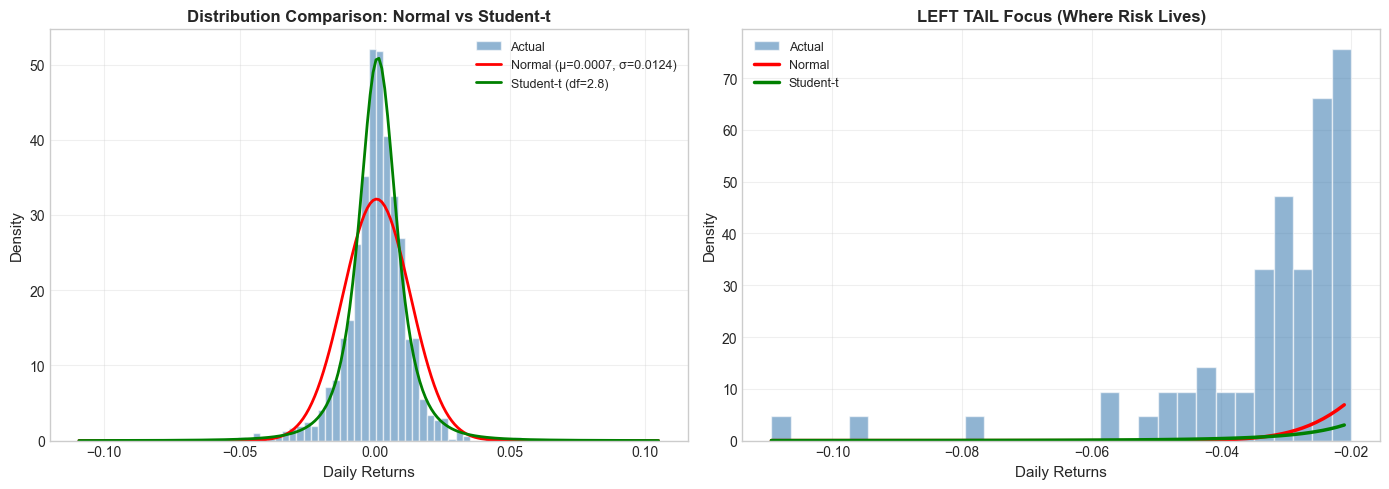


📈 Key Insight: Student-t captures tail events that Normal misses!


In [3]:
# Fit Student-t distribution to SPY returns
# MLE estimation of df, loc, scale
df_t, loc_t, scale_t = stats.t.fit(spy_returns)

print("=" * 60)
print("FITTING STUDENT-T DISTRIBUTION TO SPY RETURNS")
print("=" * 60)
print(f"\nEstimated Parameters:")
print(f"  Degrees of Freedom (ν): {df_t:.2f}")
print(f"  Location (μ):           {loc_t:.6f}")
print(f"  Scale (σ):              {scale_t:.6f}")
print(f"\n💡 df = {df_t:.1f} indicates {'heavy' if df_t < 5 else 'moderate'} tails")
print(f"   (Lower df = heavier tails, df → ∞ = Normal)")

# Create fitted distribution
t_dist = stats.t(df=df_t, loc=loc_t, scale=scale_t)

# Compare Normal vs Student-t in the tails
print("\n" + "=" * 60)
print("TAIL PROBABILITY COMPARISON (Extreme Events)")
print("=" * 60)

# Calculate probability of extreme events
thresholds = [2, 3, 4, 5]  # Standard deviations
print(f"\n{'Event':<25} {'Normal':<15} {'Student-t':<15} {'Actual':<10}")
print("-" * 65)

for n_std in thresholds:
    threshold = mu_normal - n_std * sigma_normal
    p_normal = normal_dist.cdf(threshold)
    p_t = t_dist.cdf(threshold)
    p_actual = (spy_returns < threshold).mean()
    
    print(f"Return < -{n_std}σ ({threshold:.3%})"
          f"    {p_normal:.6f}      {p_t:.6f}        {p_actual:.6f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PDF comparison
axes[0].hist(spy_returns, bins=80, density=True, alpha=0.6, 
             color='steelblue', edgecolor='white', label='Actual')
axes[0].plot(x_range, normal_dist.pdf(x_range), 'r-', lw=2, 
             label=f'Normal (μ={mu_normal:.4f}, σ={sigma_normal:.4f})')
axes[0].plot(x_range, t_dist.pdf(x_range), 'g-', lw=2, 
             label=f'Student-t (df={df_t:.1f})')
axes[0].set_xlabel('Daily Returns', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Distribution Comparison: Normal vs Student-t', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Focus on left tail (risk perspective)
left_tail = x_range[x_range < -0.02]
axes[1].hist(spy_returns[spy_returns < -0.02], bins=30, density=True, 
             alpha=0.6, color='steelblue', edgecolor='white', label='Actual')
axes[1].plot(left_tail, normal_dist.pdf(left_tail), 'r-', lw=2.5, label='Normal')
axes[1].plot(left_tail, t_dist.pdf(left_tail), 'g-', lw=2.5, label='Student-t')
axes[1].set_xlabel('Daily Returns', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('LEFT TAIL Focus (Where Risk Lives)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Key Insight: Student-t captures tail events that Normal misses!")

## 3. Log-Normal Distribution - Modeling Prices

While returns can be negative, **prices cannot**. The Log-Normal distribution models this:

$$\ln(P_t) \sim N(\mu, \sigma^2)$$

**Properties:**
- Always positive (prices can't go negative)
- If log-returns are Normal, prices are Log-Normal
- Foundation of Black-Scholes option pricing
- Price at time t: $P_t = P_0 \cdot e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t}$

**Geometric Brownian Motion (GBM):**
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

LOG-NORMAL DISTRIBUTION FOR PRICES

Log-Return Parameters:
  Mean (μ):   0.000634 (15.99% annualized)
  Std (σ):    0.012451 (19.77% annualized)

Normality Comparison:
  Simple returns p-value: 1.924933e-88
  Log returns p-value:    1.157594e-103
  Winner: Simple returns (closer to Normal)


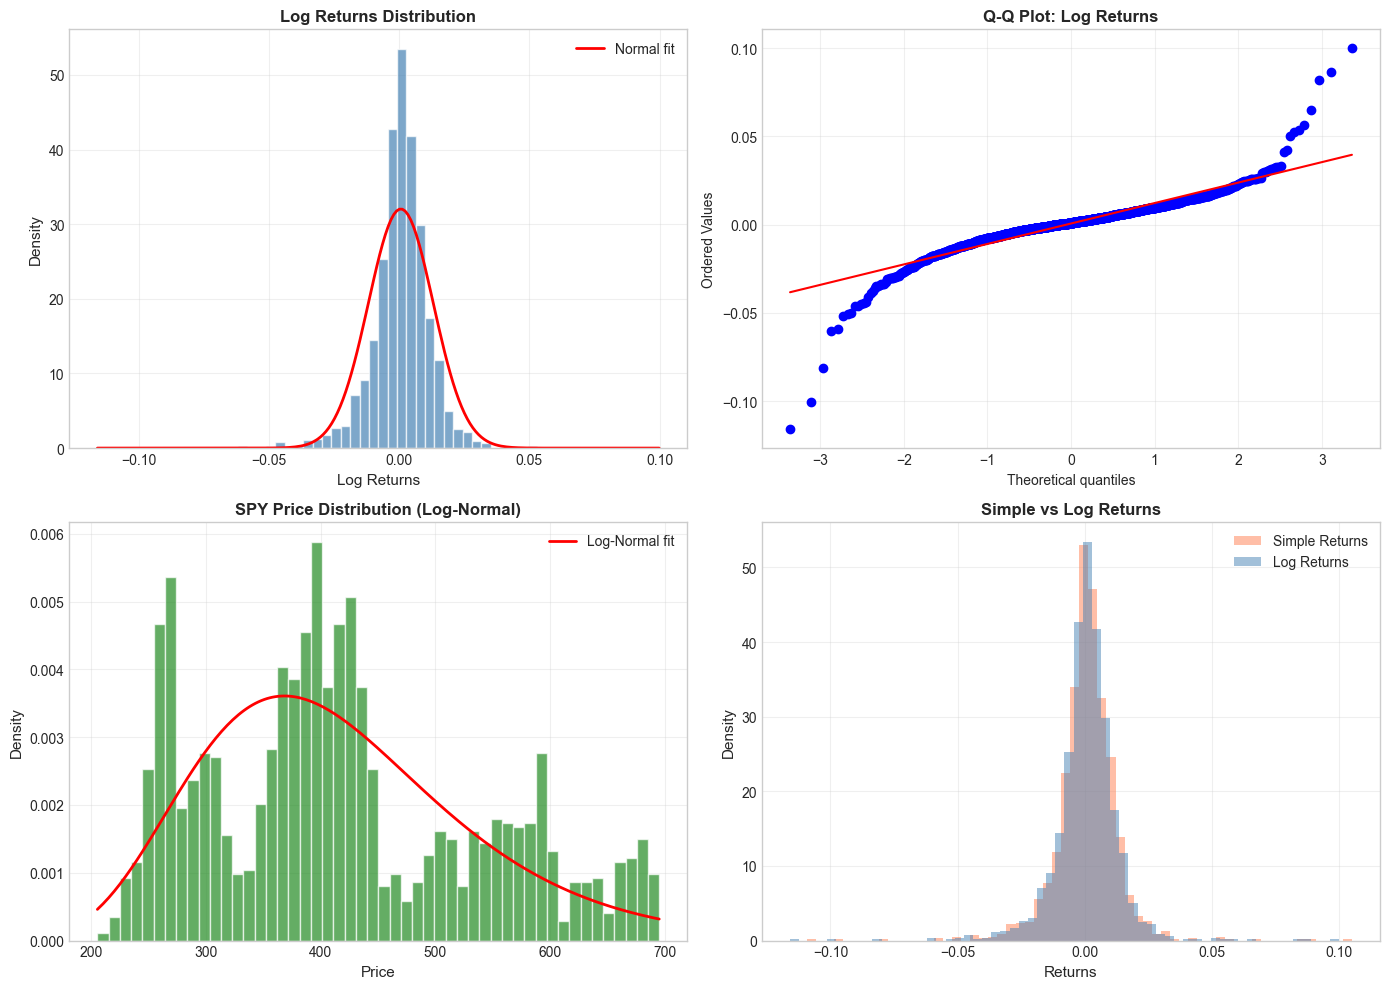


📊 Key Insight: Log returns ≈ Simple returns for small values
   but diverge for large moves. Both are NOT perfectly Normal!


In [4]:
# Log-Normal Distribution for Prices
spy_prices = prices['SPY'].values

# Calculate log returns
log_returns = np.log(prices['SPY'] / prices['SPY'].shift(1)).dropna().values

print("=" * 60)
print("LOG-NORMAL DISTRIBUTION FOR PRICES")
print("=" * 60)

# Fit normal to log-returns
mu_log = np.mean(log_returns)
sigma_log = np.std(log_returns)

print(f"\nLog-Return Parameters:")
print(f"  Mean (μ):   {mu_log:.6f} ({mu_log * 252:.2%} annualized)")
print(f"  Std (σ):    {sigma_log:.6f} ({sigma_log * np.sqrt(252):.2%} annualized)")

# Test if log-returns are more Normal than simple returns
stat_simple, p_simple = stats.normaltest(spy_returns)
stat_log, p_log = stats.normaltest(log_returns)

print(f"\nNormality Comparison:")
print(f"  Simple returns p-value: {p_simple:.6e}")
print(f"  Log returns p-value:    {p_log:.6e}")
print(f"  Winner: {'Log returns' if p_log > p_simple else 'Simple returns'} (closer to Normal)")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Log returns histogram
axes[0, 0].hist(log_returns, bins=60, density=True, alpha=0.7, 
                color='steelblue', edgecolor='white')
x_log = np.linspace(log_returns.min(), log_returns.max(), 200)
axes[0, 0].plot(x_log, stats.norm.pdf(x_log, mu_log, sigma_log), 
                'r-', lw=2, label='Normal fit')
axes[0, 0].set_xlabel('Log Returns', fontsize=11)
axes[0, 0].set_ylabel('Density', fontsize=11)
axes[0, 0].set_title('Log Returns Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Q-Q plot for log returns
stats.probplot(log_returns, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot: Log Returns', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Price distribution (should be log-normal)
axes[1, 0].hist(spy_prices, bins=50, density=True, alpha=0.7, 
                color='forestgreen', edgecolor='white')
# Fit log-normal to prices
shape, loc, scale = stats.lognorm.fit(spy_prices, floc=0)
x_price = np.linspace(spy_prices.min(), spy_prices.max(), 200)
axes[1, 0].plot(x_price, stats.lognorm.pdf(x_price, shape, loc, scale), 
                'r-', lw=2, label='Log-Normal fit')
axes[1, 0].set_xlabel('Price', fontsize=11)
axes[1, 0].set_ylabel('Density', fontsize=11)
axes[1, 0].set_title('SPY Price Distribution (Log-Normal)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Simple vs Log returns comparison
axes[1, 1].hist(spy_returns, bins=60, density=True, alpha=0.5, 
                color='coral', label='Simple Returns')
axes[1, 1].hist(log_returns, bins=60, density=True, alpha=0.5, 
                color='steelblue', label='Log Returns')
axes[1, 1].set_xlabel('Returns', fontsize=11)
axes[1, 1].set_ylabel('Density', fontsize=11)
axes[1, 1].set_title('Simple vs Log Returns', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Insight: Log returns ≈ Simple returns for small values")
print("   but diverge for large moves. Both are NOT perfectly Normal!")

## 4. VaR: Practical Application of Distributions

**Value at Risk (VaR)** quantifies potential losses using distribution assumptions:

$$\text{VaR}_\alpha = F^{-1}(\alpha)$$

Where $F^{-1}$ is the inverse CDF (quantile function) and $\alpha$ is typically 1% or 5%.

**Parametric VaR Methods:**
- **Normal VaR**: Uses Normal distribution quantiles
- **Student-t VaR**: More conservative, captures tail risk
- **Historical VaR**: Non-parametric, uses actual return quantiles

VALUE AT RISK (VaR) - DISTRIBUTION COMPARISON

Portfolio Value: $1,000,000

------------------------------------------------------------
Confidence      Historical      Normal          Student-t      
------------------------------------------------------------
99% VaR         -3.43%          -2.82%          -3.31%
95% VaR         -1.76%          -1.97%          -1.62%
90% VaR         -1.18%          -1.52%          -1.08%

VaR IN DOLLAR TERMS (1-Day)

Confidence      Historical      Normal          Student-t      
------------------------------------------------------------
99% VaR         $    34,252     $    28,187     $    33,115
95% VaR         $    17,644     $    19,721     $    16,173
90% VaR         $    11,832     $    15,208     $    10,798


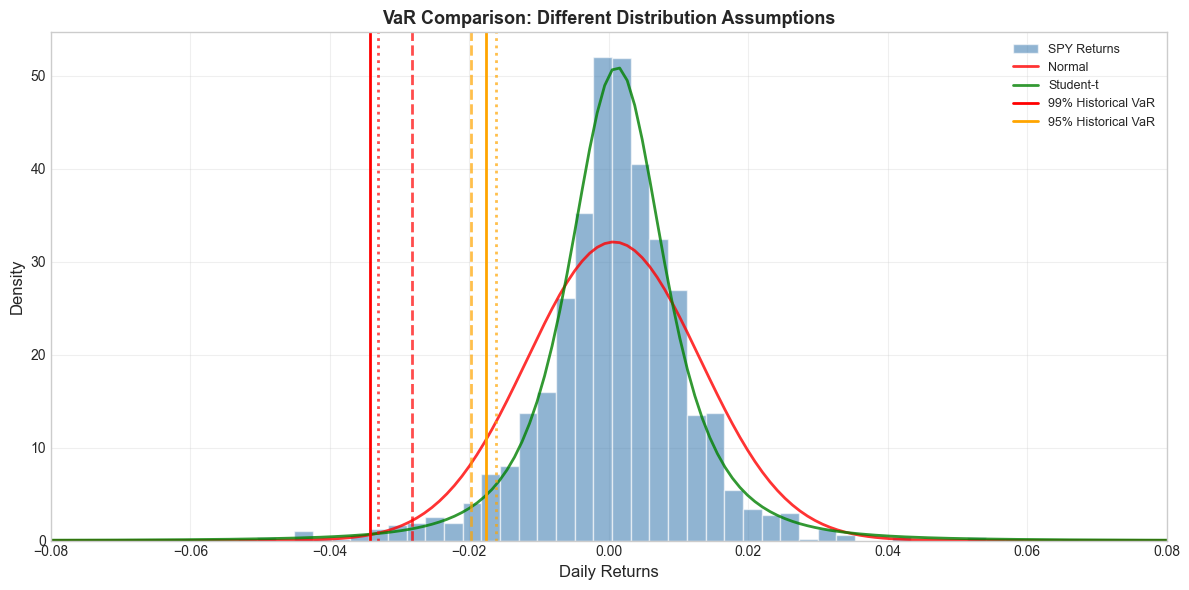


⚠️ Key Risk Insight:
   Normal VaR UNDERESTIMATES tail risk!
   Student-t or Historical VaR is more conservative.


In [5]:
# VaR Calculation: Comparing Distribution Assumptions
print("=" * 60)
print("VALUE AT RISK (VaR) - DISTRIBUTION COMPARISON")
print("=" * 60)

confidence_levels = [0.01, 0.05, 0.10]  # 99%, 95%, 90% confidence
portfolio_value = 1_000_000  # $1M portfolio

print(f"\nPortfolio Value: ${portfolio_value:,.0f}")
print("\n" + "-" * 60)
print(f"{'Confidence':<15} {'Historical':<15} {'Normal':<15} {'Student-t':<15}")
print("-" * 60)

var_results = {}
for alpha in confidence_levels:
    # Historical VaR (non-parametric)
    var_hist = np.percentile(spy_returns, alpha * 100)
    
    # Normal VaR (parametric)
    var_normal = normal_dist.ppf(alpha)
    
    # Student-t VaR (parametric, fat tails)
    var_t = t_dist.ppf(alpha)
    
    var_results[alpha] = {
        'historical': var_hist,
        'normal': var_normal,
        'student_t': var_t
    }
    
    print(f"{1-alpha:.0%} VaR"
          f"         {var_hist:.2%}"
          f"          {var_normal:.2%}"
          f"          {var_t:.2%}")

print("\n" + "=" * 60)
print("VaR IN DOLLAR TERMS (1-Day)")
print("=" * 60)
print(f"\n{'Confidence':<15} {'Historical':<15} {'Normal':<15} {'Student-t':<15}")
print("-" * 60)

for alpha in confidence_levels:
    var_h = abs(var_results[alpha]['historical']) * portfolio_value
    var_n = abs(var_results[alpha]['normal']) * portfolio_value
    var_t = abs(var_results[alpha]['student_t']) * portfolio_value
    print(f"{1-alpha:.0%} VaR"
          f"         ${var_h:>10,.0f}"
          f"     ${var_n:>10,.0f}"
          f"     ${var_t:>10,.0f}")

# Visualize VaR
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(spy_returns, bins=80, density=True, alpha=0.6, 
        color='steelblue', edgecolor='white', label='SPY Returns')
ax.plot(x_range, normal_dist.pdf(x_range), 'r-', lw=2, alpha=0.8, label='Normal')
ax.plot(x_range, t_dist.pdf(x_range), 'g-', lw=2, alpha=0.8, label='Student-t')

# Mark VaR levels
colors = ['red', 'orange', 'gold']
for i, alpha in enumerate([0.01, 0.05]):
    ax.axvline(var_results[alpha]['historical'], color=colors[i], 
               linestyle='-', lw=2, label=f'{1-alpha:.0%} Historical VaR')
    ax.axvline(var_results[alpha]['normal'], color=colors[i], 
               linestyle='--', lw=2, alpha=0.7)
    ax.axvline(var_results[alpha]['student_t'], color=colors[i], 
               linestyle=':', lw=2, alpha=0.7)

ax.set_xlabel('Daily Returns', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('VaR Comparison: Different Distribution Assumptions', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.08, 0.08)

plt.tight_layout()
plt.show()

print("\n⚠️ Key Risk Insight:")
print("   Normal VaR UNDERESTIMATES tail risk!")
print("   Student-t or Historical VaR is more conservative.")

## 5. Distribution Comparison Across Assets

Different assets exhibit different distributional properties. Let's compare AAPL, MSFT, SPY, and JPM.

DISTRIBUTION COMPARISON ACROSS ASSETS


Asset Mean (ann) Vol (ann) Skewness Kurtosis t-df Normal?
 AAPL     32.12%    30.99%    0.178    6.907 3.29      No
 MSFT     26.53%    28.32%    0.083    7.729 3.53      No
  SPY     17.94%    19.72%   -0.295   13.816 2.83      No
  JPM     23.64%    29.88%    0.345   13.528 2.92      No

💡 Interpretation Guide:
   Skewness: 0 = symmetric, < 0 = left skew (more crashes)
   Kurtosis: 0 = Normal, > 0 = fat tails (leptokurtic)
   t-df:     Lower = heavier tails (typically 3-5 for stocks)


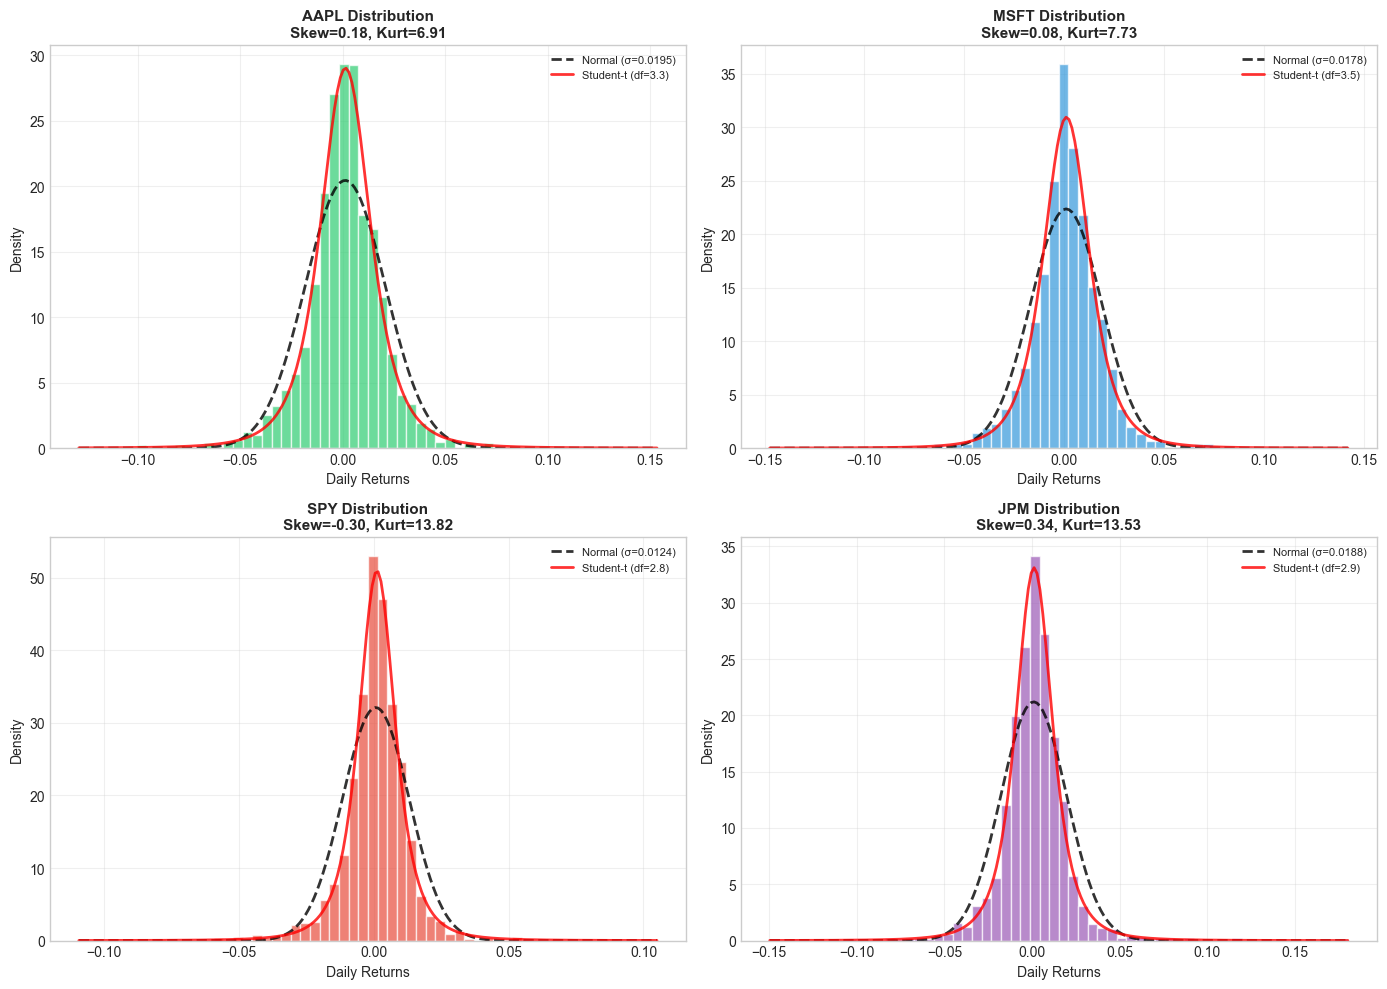

In [6]:
# Compare distributions across multiple assets
print("=" * 60)
print("DISTRIBUTION COMPARISON ACROSS ASSETS")
print("=" * 60)

assets = ['AAPL', 'MSFT', 'SPY', 'JPM']
results = []

for asset in assets:
    r = returns[asset].values
    
    # Basic stats
    mu = np.mean(r)
    sigma = np.std(r)
    skew = stats.skew(r)
    kurt = stats.kurtosis(r)  # Excess kurtosis (0 for Normal)
    
    # Fit Student-t
    df_t, _, _ = stats.t.fit(r)
    
    # Normality test
    _, p_val = stats.normaltest(r)
    
    results.append({
        'Asset': asset,
        'Mean (ann)': mu * 252,
        'Vol (ann)': sigma * np.sqrt(252),
        'Skewness': skew,
        'Kurtosis': kurt,
        't-df': df_t,
        'Normal?': 'Yes' if p_val > 0.05 else 'No'
    })

results_df = pd.DataFrame(results)
print("\n")
print(results_df.to_string(index=False, 
    formatters={
        'Mean (ann)': '{:.2%}'.format,
        'Vol (ann)': '{:.2%}'.format,
        'Skewness': '{:.3f}'.format,
        'Kurtosis': '{:.3f}'.format,
        't-df': '{:.2f}'.format
    }))

print("\n💡 Interpretation Guide:")
print("   Skewness: 0 = symmetric, < 0 = left skew (more crashes)")
print("   Kurtosis: 0 = Normal, > 0 = fat tails (leptokurtic)")
print("   t-df:     Lower = heavier tails (typically 3-5 for stocks)")

# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for i, asset in enumerate(assets):
    r = returns[asset].values
    
    # Histogram
    axes[i].hist(r, bins=60, density=True, alpha=0.7, 
                 color=colors[i], edgecolor='white')
    
    # Normal fit
    mu, sigma = np.mean(r), np.std(r)
    x = np.linspace(r.min(), r.max(), 200)
    axes[i].plot(x, stats.norm.pdf(x, mu, sigma), 'k--', lw=2, 
                 label=f'Normal (σ={sigma:.4f})', alpha=0.8)
    
    # Student-t fit
    df_t, loc_t, scale_t = stats.t.fit(r)
    axes[i].plot(x, stats.t.pdf(x, df_t, loc_t, scale_t), 'r-', lw=2, 
                 label=f'Student-t (df={df_t:.1f})', alpha=0.8)
    
    axes[i].set_xlabel('Daily Returns', fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].set_title(f'{asset} Distribution\nSkew={stats.skew(r):.2f}, Kurt={stats.kurtosis(r):.2f}', 
                      fontsize=11, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Practice Exercise: Distribution Analysis

**Challenge:** Analyze a portfolio of equal-weighted stocks and answer:
1. Does portfolio diversification make returns more Normal?
2. Calculate the 99% VaR using all three methods

PRACTICE: EQUAL-WEIGHTED PORTFOLIO ANALYSIS

Comparing Individual Assets vs Equal-Weight Portfolio:
--------------------------------------------------

Portfolio Stats:
  Annual Return:  25.06%
  Annual Vol:     22.99%
  Skewness:       -0.029
  Kurtosis:       14.338
  Student-t df:   2.95
  Normal?         No

Diversification Effect:
  Avg Individual Vol: 27.23%
  Portfolio Vol:      22.99%
  Vol Reduction:      15.6%

  Avg Individual Kurt: 10.49
  Portfolio Kurt:      14.34
  Tail Risk Change:    Increased

99% VaR COMPARISON (Portfolio)

  Historical 99% VaR: -3.96%
  Normal 99% VaR:     -3.27%
  Student-t 99% VaR:  -3.82%


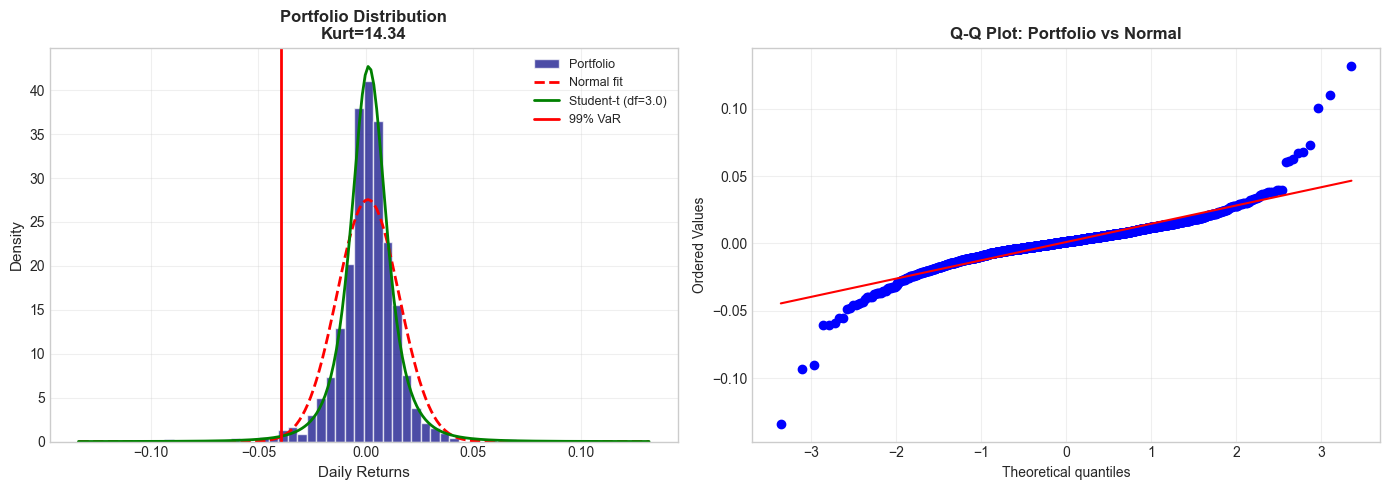


📊 Key Finding:
   Diversification reduces volatility but returns still have fat tails!


In [7]:
# Practice: Portfolio Distribution Analysis
print("=" * 60)
print("PRACTICE: EQUAL-WEIGHTED PORTFOLIO ANALYSIS")
print("=" * 60)

# Create equal-weighted portfolio returns
portfolio_returns = returns[assets].mean(axis=1).values

# Compare individual asset to portfolio
print("\nComparing Individual Assets vs Equal-Weight Portfolio:")
print("-" * 50)

# Portfolio stats
port_mu = np.mean(portfolio_returns)
port_sigma = np.std(portfolio_returns)
port_skew = stats.skew(portfolio_returns)
port_kurt = stats.kurtosis(portfolio_returns)
df_port, _, _ = stats.t.fit(portfolio_returns)
_, p_port = stats.normaltest(portfolio_returns)

# Average individual stats
avg_vol = np.mean([np.std(returns[a]) for a in assets])
avg_kurt = np.mean([stats.kurtosis(returns[a]) for a in assets])

print(f"\nPortfolio Stats:")
print(f"  Annual Return:  {port_mu * 252:.2%}")
print(f"  Annual Vol:     {port_sigma * np.sqrt(252):.2%}")
print(f"  Skewness:       {port_skew:.3f}")
print(f"  Kurtosis:       {port_kurt:.3f}")
print(f"  Student-t df:   {df_port:.2f}")
print(f"  Normal?         {'Yes' if p_port > 0.05 else 'No'}")

print(f"\nDiversification Effect:")
print(f"  Avg Individual Vol: {avg_vol * np.sqrt(252):.2%}")
print(f"  Portfolio Vol:      {port_sigma * np.sqrt(252):.2%}")
print(f"  Vol Reduction:      {(1 - port_sigma / avg_vol):.1%}")
print(f"\n  Avg Individual Kurt: {avg_kurt:.2f}")
print(f"  Portfolio Kurt:      {port_kurt:.2f}")
print(f"  Tail Risk Change:    {'Reduced' if port_kurt < avg_kurt else 'Increased'}")

# Portfolio VaR comparison
print("\n" + "=" * 60)
print("99% VaR COMPARISON (Portfolio)")
print("=" * 60)

# Fit distributions
port_normal = stats.norm(loc=port_mu, scale=port_sigma)
port_t = stats.t(*stats.t.fit(portfolio_returns))

var_hist = np.percentile(portfolio_returns, 1)
var_normal = port_normal.ppf(0.01)
var_t = port_t.ppf(0.01)

print(f"\n  Historical 99% VaR: {var_hist:.2%}")
print(f"  Normal 99% VaR:     {var_normal:.2%}")
print(f"  Student-t 99% VaR:  {var_t:.2%}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Portfolio distribution
axes[0].hist(portfolio_returns, bins=60, density=True, alpha=0.7, 
             color='navy', edgecolor='white', label='Portfolio')
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 200)
axes[0].plot(x, port_normal.pdf(x), 'r--', lw=2, label='Normal fit')
axes[0].plot(x, port_t.pdf(x), 'g-', lw=2, label=f'Student-t (df={df_port:.1f})')
axes[0].axvline(var_hist, color='red', lw=2, label='99% VaR')
axes[0].set_xlabel('Daily Returns', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title(f'Portfolio Distribution\nKurt={port_kurt:.2f}', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(portfolio_returns, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Portfolio vs Normal', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Finding:")
print("   Diversification reduces volatility but returns still have fat tails!")

## 📝 Key Takeaways - Day 1

### Distribution Facts for Quant Interviews:

1. **Normal Distribution Fails**
   - Real returns have fat tails (leptokurtic)
   - Returns exhibit negative skewness
   - Volatility is not constant

2. **Student-t is More Realistic**
   - Captures fat tails with degrees of freedom parameter
   - Typical df = 3-5 for stock returns
   - More conservative VaR estimates

3. **Log-Normal for Prices**
   - If log returns ~ Normal, prices ~ Log-Normal
   - Foundation of Black-Scholes
   - Ensures prices stay positive

4. **VaR Implications**
   - Normal VaR underestimates tail risk
   - Historical VaR is non-parametric
   - Student-t VaR is more conservative

### Interview Questions to Prepare:
- "Why do we use log returns instead of simple returns?"
- "How do fat tails affect risk management?"
- "What's the difference between Normal and Student-t VaR?"
- "Does diversification eliminate tail risk?"